# **Assignment 3 - Sentiment Analysis for 2019 Canadian Election**

**Course**: MIE1624 - Introduction to Data Science and Analytics

**Professor**: Dr. Oleksandr Romanko, PhD.

**Due Date**:  11:59pm, 29 Mar 2021

**Student**:  Sugumar Prabhakaran (**id#**: 994126815)

In [1]:
#collection of all imported libraries used in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#DATA CLEANING
import re                                       # regular expressions
import html                                     # convert html to ascii
import nltk                                     
from nltk.tokenize import word_tokenize         # split text into word-list
from nltk.corpus import stopwords               # collection of stop words
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer             # stem words

#EXPLORATORY DATA ANALYSIS
from collections import defaultdict
from wordcloud import WordCloud

#PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#ML MODELS
from tqdm.notebook import tqdm_notebook, trange # progress bar
import time                                     # to track execution time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.svm import LinearSVC               # Support Vector Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

#HYPERPARAMETER TUNING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# read sentiment_analysis.csv file
df = pd.read_csv('sentiment_analysis.csv', low_memory=False)
print("df shape: ", df.shape, '\n')
df.head()

df shape:  (550391, 3) 



,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


### **1. Data Cleaning [20 marks]**

The tweets, as given, are not in a form amenable to analysis –-- there is too much ‘noise’.  Therefore, the first step is to “clean” the data. Design a procedure that prepares the
Twitter data for analysis by satisfying the requirements below.
* All html tags and attributes (i.e., /<[^>]+>/) are removed.
* Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
* All URLs are removed.
* All characters in the text are in lowercase.
* All stop words are removed. Be clear in what you consider as a stop word.
* If a tweet is empty after pre-processing, it should be preserved as such.

In [3]:
#References: 
# https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d
# https://medium.com/@jeevanchavan143/nlp-tokenization-stemming-lemmatization-bag-of-words-tf-idf-pos-7650f83c60be

#1. REMOVE ALL HTML TAGS AND ATTRIBUTES OF FORM: '<'misc characters'>':
def remove_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'^RT|^b"','', text) # 'RT' in generic and 'b"' in election
    text = re.sub(r'\ {2,}','', text)   # remove spaces>2
    return text

#2. CONVERT HTML CHARACTER CODES TO ASCII
def html_to_ascii(text):
    return html.unescape(text)

#3. REMOVE ALL URLS:
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#4. FOR LOWERCASE, USE LAMBDA FUNCTION (see batch_clean func. in next cell)

#EXTRA 1. REMOVE USERS (Ex. @harry_potter, @batman): SENTIMENT_ANALYSIS ONLY
def remove_users(text):
    return re.sub(r'@\S+', '', text)

#EXTRA 2. REMOVE EMOJIS, PUNCTUATION & DIGITS:
def remove_extras(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'[0-9]','', text)
    return text

#5A.REMOVE STOPWORDS:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokenized_list = word_tokenize(text)    # tokenize
    filtered_list = [x for x in tokenized_list if x not in stop_words]
    return ' '.join(filtered_list)          # untokenize

#5B.STEM WORDS:
def stem_words(text):
    ps = PorterStemmer()
    tokenized_list = word_tokenize(text)
    stemmed_list = [ps.stem(x) for x in tokenized_list]
    return ' '.join(stemmed_list)

In [4]:
# combine common cleaning tasks into 1 function: batch_clean to be used on both
# Sentiment_Analysis.csv and Canadian_Election_2019.csv
def batch_clean(Series):
    Series = Series.apply(remove_tags)                  #1 remove tags
    Series = Series.apply(html_to_ascii)                #2 html >> ascii
    Series = Series.apply(remove_urls)                  #3 remove URLS
    Series = Series.apply(lambda x: x.lower())          #4 lower_case
    return Series

#### **1.1 Data Cleaning - Generic Sentiment Analysis Twitter Data**

In this section, we use the functions defined above to clean the generic twitter data from the file ***sentiment_analysis.csv***.

Steps for cleaning this data-set:
1. copy text into a new column
2. use custom generic **batch_clean** function to:
    * remove tags and urls
    * convert html to ascii
    * convert to lower case
3. complete specific cleaning tasks for this dataset:
    * remove usernames (ex. @harrypotter @soccer_kid)
    * remove extras: emojis, punctuation and digits
    * remove stop-words and conduct stemming

In [5]:
df['clean_text'] = df['text'].astype(str)               #copy 'text' to new col
df['clean_text'] = batch_clean(df['clean_text'])        #batch clean
df['clean_text'] = df['clean_text'].apply(remove_users) #Extra 1. remove users
df['clean_text'] = df['clean_text'].apply(remove_extras)#Extra 2. remove extras
df['clean_text'] = df['clean_text'].apply(remove_stopwords)   

In [6]:
pd.set_option('max_rows',100, 'max_colwidth', 150)
df.head(10)

,ID,text,label,clean_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,1,josh jenkins looking forward tab breeders crown super sunday
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,1,congratulations pakistan becoming notestteam world odds ji_pakzindabadrallies
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",1,september taking maine mendozas surprise thanksgiving party threw fans
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",1,newly painted walls thanks million custodial painters summergreat job ladiesec_proud
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,1,excited announce july feschotte lab relocating mbg
5,7.680980e+17,RT @SH4WNSMILE: -Who is excited for illuminate !? -.... https://t.co/AKnIVEGUOe,1,excited illuminate
6,7.680980e+17,RT @KendallHuntRPD: The #firstdayofschool for students &amp; teachers. Good luck and have a Successful 2016-17 School Year #EducationMatters ht…,1,firstdayofschool students teachers good luck successful school year educationmatters ht
7,7.680980e+17,RT @BantySrkian: #SRK and kajol in the making of DDLJ song .. Both are greatest ever 🙏🙏🙏 https://t.co/Aa7fAvvtNE,1,srk kajol making ddlj song greatest ever
8,7.680980e+17,RT @GayHopper_com: I'm happy! https://t.co/fKXbN3Zhtd,1,im happy
9,7.680980e+17,"RT @StarCinema: Kathryn, Daniel share memorable experience in Barcelona SEE INTERVIEW HERE: https://t.co/Vub69JTdKL https://t.co/NntyQWs7To",1,kathryn daniel share memorable experience barcelona see interview


#### **1.2 Data Cleaning - Canadian Election 2019 Data**

In this section, we do a similar clean to ***Canadian_elections_2019.csv*** data.

Steps for cleaning this data-set:
1. encode **'sentiment'** column from positive/negative to 1/0
2. copy text into a new column
3. use custom generic **batch_clean** function to:
    * remove tags and urls
    * convert html to ascii
    * convert to lower case
4. complete specific cleaning tasks for this dataset:
    * **don't remove users** since we can use user handles (ex. **@justintrudeau**) to determine political party affiliation 
    * remove extras: emojis, punctuation and digits
    * remove stop-words.


In [7]:
# read Canadian Elections 2019 .csv file
df2 = pd.read_csv('Canadian_elections_2019.csv', low_memory=False)
print("df2 shape: ", df.shape, '\n')
df2.head()

df2 shape:  (550391, 4) 



,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Cons..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of ..."


In [8]:
#confirm there are only two types of values: positive and negative
df2.sentiment.value_counts()

positive    1127
negative    1006
Name: sentiment, dtype: int64

In [9]:
#encode 'positive' and 'negative' as 1 and 0 respectively:
df2['sentiment'] = df2['sentiment'].map({'positive':1,'negative':0}).astype(int)
df2.sentiment.value_counts()

1    1127
0    1006
Name: sentiment, dtype: int64

In [10]:
#clean Canadian_Election_2019.csv data:
df2['clean_text'] = df2['text']                     #save text in new col
df2['clean_text'] = batch_clean(df2['clean_text'])  #batch cleaning
# additional cleaning tasks specific to this dataset
df2['clean_text'] = df2['clean_text'].apply(remove_extras)
df2['clean_text'] = df2['clean_text'].apply(remove_stopwords)

In [11]:
df2.head(10)

,sentiment,negative_reason,text,clean_text
0,0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Cons...",rosiebarton instead suggestion agree canadian women trust andrewscheer conservatives government protect womans right automony body lets go thatcdn...
1,1,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ""",allwomanspacewalk realnspace_station netobicokenorth cityofto onpoli cdnpoli elxn
2,0,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972""",brantford going cost billion next years ask justin elxn cdnpoli canada
3,1,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6""",canada canadaelection canadavotes nelxn nncant decide helpnn
4,0,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of ...",canada taxpayers sick tired hard earned donated corporate welfare bums dont need one many reasons trudeaumustgo snclavalin leave canada care sheil...
5,0,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - #BlastFromThePast - In 2012 #Conservatives introduced the end of the long-gun registry even though a...",canadavotes elxn cdnpoli facts blastfromthepast conservatives introduced end longgun registry even though heads police across canada victims group...
6,1,NaN,"b""#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong hands down has the best election video ever. Please google Rocky Dong boxes socialism if you haven't ...",cdnmedia elxn cdnpoli ppc rocky dong hands best election video ever please google rocky dong boxes socialism havent seen go rocky
7,1,NaN,"b""#cdnpoli #elxn43 The Liberals ++ more than double what was promised in 2015, to the national debt. Now for the next term - if re-elected, they'r...",cdnpoli elxn liberals double promised national debt next term reelected theyre forecasting billion wout national pharmacare program incl wout ndp ...
8,0,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don't Make America's Mistakes | Full Frontal on TBS https://t.co/PhU4jHxnMF via @YouTube""",chooseforward cdnpoli elxnncanada dont make americas mistakes full frontal tbs via youtube
9,0,Scandal,"b""#CPCKinsellaGate\nLet's see the receipts. Who pays Warren Kinsella to make up sleaze?\n#cdnpoli\n#elxn43 \n#VoteLiberal \xf0\x9f\x87\xa8\xf0\x9f...",cpckinsellagatenlets see receipts pays warren kinsella make sleazencdnpolinelxn nvoteliberal xfxfxxaxfxfxxanchooseforward


### **2. Exploratory Data Analysis [15 marks]**




#### **2.1 Simple Procedure to Determine Political Party**

* Design a simple procedure that determines the political party (Liberal, Conservatives or New Democratic Party (NDC)) of a given tweet and apply this procedure to all the tweets in the Canadian Elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties or candidates.

In [12]:
#bag-of-words vectorize into word-count-matrix and then convert to df
cv_election = CountVectorizer(min_df=50)
word_count_matrix = cv_election.fit_transform(df2['clean_text'].astype(str))
word_count_df = pd.DataFrame.sparse.from_spmatrix(
    word_count_matrix, columns=cv_election.get_feature_names())

#preview of top 15 words.  We will use top-100 to define function in next cell
word_count_df.sum(axis=0).sort_values(ascending=False)[0:15]

elxn             1719
cdnpoli           845
vote              245
election          207
canada            194
scheer            171
party             166
andrewscheer      155
trudeau           148
cpc               142
like              133
ndp               127
people            121
chooseforward     118
campaign          117
dtype: int64

In [13]:
#function to determine party based on which party has most words in text:
#these words below were taken from the top 100 most frequntly occurring words in
#the counter list above 
def determine_party(text):
    conservative_words = ['sheer', 'andrewscheer', 'cpc','conservative','cpc_hq',
                      'conservatives','time','trudeaumustgo','andrew','abpoli',
                      'alberta']
    liberal_words = ['trudeau','justintrudeau','chooseforward','kinsella',
                     'liberal','liberals','kinsellagate','justin','liberal_party',
                     'scheerlies','cbckatie','lpc']
    ndp_words = ['ndp','thejagmeetsingh','liberals','uprisingh','jagmeet',
                 'tommulcair','mulcair','bcpoli', 'trudeaumustgo', 'climate', 
                 'people']
    
    con_count = 0       # count of conservative words in text
    lib_count = 0       # count of liberal words in text
    ndp_count = 0       # count of NDPB words in text
    party = ""          # variable to store final prediction of party

    # loop through each word 'x' in text and boost count if match a party 
    for x in str(text).split(" "):
        if x in conservative_words:
            con_count += 1
        if x in liberal_words:
            lib_count += 1
        if x in ndp_words:
            ndp_count += 1

    # if party count is max, set = party variable.  Else: 'None' or "Multiple"
    if con_count > lib_count and con_count > ndp_count:
        party = "Conservative"
    elif lib_count > con_count and lib_count > ndp_count:
        party = "Liberal"
    elif ndp_count > lib_count and ndp_count > con_count:
        party = "NDP"
    elif con_count == 0 and lib_count == 0 and ndp_count == 0:
        party = "None"
    elif con_count == ndp_count or con_count == lib_count or ndp_count == lib_count:
        party = "Multiple-Tie"
    return party

None            900
Conservative    390
Liberal         378
NDP             240
Multiple-Tie    225
Name: party, dtype: int64 



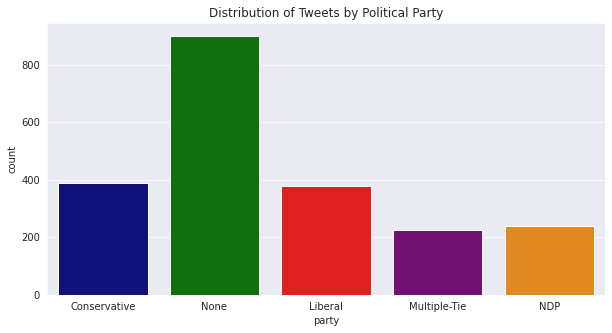

In [14]:
#apply function to determine political party
df2['party'] = df2['clean_text'].apply(determine_party)
print(df2['party'].value_counts(), '\n')

#Plot distribution of tweets by political party
sns.set_style('darkgrid')
plt.subplots(figsize=(10,5))
sns.countplot(x='party', data=df2, 
              palette=['darkblue','green','red','purple','darkorange'])
plt.title('Distribution of Tweets by Political Party')
plt.show()

**What can you say about the distribution of the political affiliations of the tweets?**

* The tweets are fairly balanced between the three major parties: Conservative, Liberal, NDP.  There is also a comparable amount of tweets that contain multiple parties in it.
* Almost 50% of the tweets belong to no party based on this algorithm.  This could be reduced with a more complex procedure for identifying the party.

* Overall, we can conclude that the election would be a close one, which aligns with reality since it was a minority-government.

#### **2.2 Visualize Generic Twitter Data**

* Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc.) that visualizes some aspect of the generic tweets in sentiment_analysis.csv 

* For 2019 Canadian Elections tweets visualization (see previous section)

In [15]:
#bag-of-words vectorize into word-count-matrix and then convert to df
cv_word = CountVectorizer(min_df=200)
word_count_matrix = cv_word.fit_transform(df['clean_text'].astype(str))
word_count_df = pd.DataFrame.sparse.from_spmatrix(
    word_count_matrix, columns=cv_word.get_feature_names())

freq_dict = defaultdict()       # dict var. to store word freqs for wordcloud

word_count = word_count_df.sum(axis=0).sort_values(ascending=False)[0:100]
for index, value in word_count.iteritems():
    freq_dict[index] = value    # convert word_count pd.Series to dictionary

In [16]:
#display top 10 words only
word_count[0:10]

love        53889
happy       51025
great       29066
good        27366
im          26243
best        25400
amazing     24498
birthday    24012
day         23510
one         17100
dtype: int64

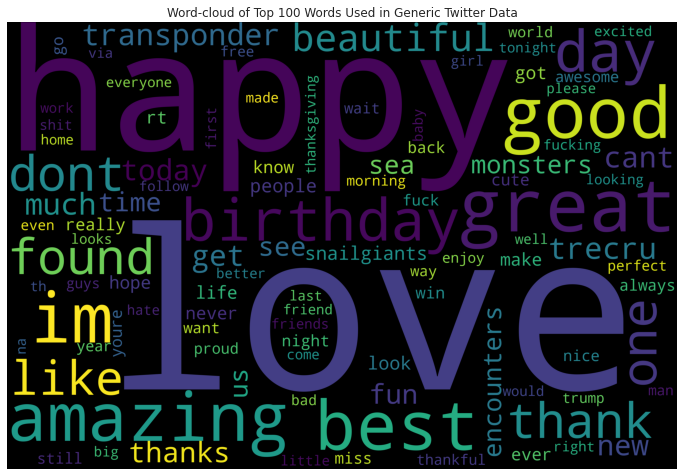

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=21).generate_from_frequencies(freq_dict)

plt.figure(figsize=(12,10))
plt.title("Word-cloud of Top 100 Words Used in Generic Twitter Data")
plt.imshow(wordcloud)
plt.axis("off");

### **3. Model Preparation [15 marks]**

In [18]:
#Need to stem 'clean_text' data in both datasets before we split
tqdm_notebook.pandas(desc="stemming...")
df['clean_text'] = df['clean_text'].progress_apply(stem_words)
df2['clean_text'] = df2['clean_text'].progress_apply(stem_words)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#### **3.1 Split Generic Twitter Data**

* Split the generic tweets randomly into training data (70%) and test data (30%). 
* In these models, the target variable is the sentiment value, which is either positive or negative. 

In [19]:
# split clean text data away from label data so we can do train_test_split
X = df['clean_text']
y = df['label']             #sentiment value (1 or 0)
print("X shape:", X.shape)
print("y shape:", y.shape, "\n")

#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X shape: (550391,)
y shape: (550391,) 

X_train shape:  (385273,)
X_test shape:  (165118,)
y_train shape:  (385273,)
y_test shape:  (165118,)


#### **3.2 Prepare Generic Twitter Data for Model Implementation**

* Prepare the data to try seven classification algorithms: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost, where each tweet is considered a single observation/example. 
* Try two different types of features, Bag of Words (word frequency) and TF-IDF on all 7 models. (Hint: Be careful about
when to split the dataset into training and testing set.)

In [20]:
# Reference: https://stackoverflow.com/questions/53451694/word-count-matrix-of-document-corpus-with-pandas-dataframe/53451785
# used to understand how to reduce size.  Filter min word count (min_df) = 100

# Vectorize X_train and X_test into TF-IDF matrices
cv_vectorizer = CountVectorizer(min_df=50)
X_train_cv_matrix = cv_vectorizer.fit_transform(X_train.astype(str))
X_test_cv_matrix = cv_vectorizer.transform(X_test.astype(str))

print("X_train_cv_matrix shape: ", X_train_cv_matrix.shape)
print("X_test_cv_matrix shape: ", X_test_cv_matrix.shape)

X_train_cv_matrix shape:  (385273, 4710)
X_test_cv_matrix shape:  (165118, 4710)


In [21]:
# Vectorize X_train and X_test into TF-IDF matrices
tfidf_vectorizer = TfidfVectorizer(min_df=50)
X_train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train.astype(str))
X_test_tfidf_matrix = tfidf_vectorizer.transform(X_test.astype(str))

print("X_train_tfidf_matrix shape: ", X_train_tfidf_matrix.shape)
print("X_test_tfidf_matrix shape: ", X_test_tfidf_matrix.shape)

X_train_tfidf_matrix shape:  (385273, 4710)
X_test_tfidf_matrix shape:  (165118, 4710)


In [22]:
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

# Since the datasets are so big, we need to do dimensionality reduction
# PCA was not recommended for sparse matrix since it centers data before SVD
svd_cv = TruncatedSVD(n_components = 100, random_state=21)
X_train_cv_svd = svd_cv.fit_transform(X_train_cv_matrix)
X_test_cv_svd = svd_cv.transform(X_test_cv_matrix)

print("Variance Explained by first 100 components of X_train_cv_matrix: {:.2%}".format(
    svd_cv.explained_variance_ratio_.sum()))

Variance Explained by first 100 components of X_train_cv_matrix: 36.96%


In [23]:
svd_tfidf = TruncatedSVD(n_components = 100, random_state=21)
X_train_tfidf_svd = svd_tfidf.fit_transform(X_train_tfidf_matrix)
X_test_tfidf_svd = svd_tfidf.transform(X_test_tfidf_matrix)
print("X_train_tfidf_svd shape: ", X_train_tfidf_svd.shape)
print("X_test_tfidf_svd shape: ", X_test_tfidf_svd.shape, "\n")

print("Variance Explained by first 100 components of X_train_tfidf_matrix: {:.2%}".format(
    svd_tfidf.explained_variance_ratio_.sum()))

X_train_tfidf_svd shape:  (385273, 100)
X_test_tfidf_svd shape:  (165118, 100) 

Variance Explained by first 100 components of X_train_tfidf_matrix: 26.23%


#### **3.3 Split and Prepare Canadian Election Data**

1. Split feature data ('clean_text') and target data ('sentiment') into **X** and **y**
2. Vectorize election X using both methods:
    * bag-of-words (cv): **election_X_cv_matrix**
    * TF-IDF: **election_X_tfidf_matrix**
3. Conduct Singular Value Decomposition to reduce dimensionality of each election_X matrix to generate:
    * **election_X_cv_svd**
    * **election_X_tfidf_svd**

In [24]:
election_X = df2.clean_text     # feature data
election_y = df2.sentiment      # target data

print("election_X shape:", election_X.shape)
print("election_y shape:", election_y.shape, "\n")

#vectorize using bag-of-words and then reduce dimensionality using SVD
election_X_cv_matrix = cv_vectorizer.transform(election_X.astype(str))
print("election_X_cv_matrix shape:", election_X_cv_matrix.shape)
election_X_cv_svd = svd_cv.transform(election_X_cv_matrix)
print("election_X_cv_svd shape:", election_X_cv_svd.shape, "\n")

#vectorize using TF-IDF and then reduce dimensionality using SVD
election_X_tfidf_matrix = tfidf_vectorizer.transform(election_X.astype(str))
print("election_X_tfidf_matrix shape:", election_X_tfidf_matrix.shape)
election_X_tfidf_svd = svd_tfidf.transform(election_X_tfidf_matrix)
print("election_X_tfidf_svd shape:", election_X_tfidf_svd.shape)

election_X shape: (2133,)
election_y shape: (2133,) 

election_X_cv_matrix shape: (2133, 4710)
election_X_cv_svd shape: (2133, 100) 

election_X_tfidf_matrix shape: (2133, 4710)
election_X_tfidf_svd shape: (2133, 100)


### **4. Model Implementation and Tuning**

#### **4.1 Implement Binary Classification Models on Generic Sentiment Analysis Data**

* Train models on the training data from generic tweets and apply the model to the test data to obtain an accuracy value. 
* Evaluate the same trained model with best performance on the Canadian Elections data. 
* **How well do your predictions match the sentiment labelled in the Canadian elections data?**

In [25]:
#build a function to loop through all 7 classifier models and store accuracies
def implement_models(X_train, y_train, X_test, y_test):

    model_name = ['Log Regression', 'Naive Bayes', 'Linear SVC', 
                  'Decision Tree', 'Random Forest', 'XGBoost', 'KNN']

    model = [LogisticRegression(max_iter=1000), GaussianNB(), 
             LinearSVC(random_state=21),
             DecisionTreeClassifier(random_state=21), 
             RandomForestClassifier(random_state=21),
             XGBClassifier(), KNeighborsClassifier()]

    start = time.time()

    accuracy_list = []
    progress_bar = trange(7)
    best_score = 0
    best_predictions = np.zeros(y_test.shape[0])

    for i in progress_bar:
        progress_bar.set_description(f"Implementing Model: {model_name[i]}")
        model[i].fit(X_train, y_train)
        predictions = model[i].predict(X_test)
        end = time.time()
        score = f1_score(y_test, predictions)
        print('{} F1 Score: {:.2%} (exec time: {:.2f} secs)'.format(
            model_name[i],score,(end-start)))
        accuracy_list.append(score)
        start = end

        if score > best_score:
            best_score = score
            best_predictions = predictions

    return accuracy_list

In [ ]:
# Implementing Models on Generic Sentiment Analyis data using bag-of-words:
cv_f1_scores = implement_models(X_train_cv_svd, y_train, X_test_cv_svd, y_test)

Log Regression F1 Score: 91.32% (exec time: 12.75 secs)
Naive Bayes F1 Score: 83.23% (exec time: 0.89 secs)
Linear SVC F1 Score: 90.79% (exec time: 95.12 secs)
Decision Tree F1 Score: 90.27% (exec time: 168.90 secs)
Random Forest F1 Score: 94.24% (exec time: 835.12 secs)
XGBoost F1 Score: 90.82% (exec time: 329.19 secs)
KNN F1 Score: 92.61% (exec time: 2317.12 secs)



In [ ]:
# Implementing Models on Generic Sentiment Analyis data using TF-IDF:
tfidf_f1_scores  = implement_models(X_train_tfidf_svd, y_train, 
                                    X_test_tfidf_svd, y_test)

Log Regression F1 Score: 91.89% (exec time: 22.81 secs)
Naive Bayes F1 Score: 82.68% (exec time: 0.92 secs)
Linear SVC F1 Score: 91.77% (exec time: 11.03 secs)
Decision Tree F1 Score: 90.58% (exec time: 133.08 secs)
Random Forest F1 Score: 94.44% (exec time: 727.62 secs)
XGBoost F1 Score: 91.60% (exec time: 311.70 secs)
KNN F1 Score: 91.96% (exec time: 4471.75 secs)



In [ ]:
#Best accuracy was achieved using the  model and using TF-IDF
# so now we run it with the Canadian Election 2019 data to see its performance:
start = time.time()
model = RandomForestClassifier(random_state=21)
model.fit(X_train_tfidf_svd, y_train)
predictions = model.predict(election_X_tfidf_svd)
end = time.time()
score = f1_score(election_y, predictions)
print('Random Forest Model F1 Score: {:.2%} (exec time: {:.2f} secs)'.format(
score,(end-start)))

Random Forest Model F1 Score: 52.96% (exec time: 657.60 secs)


**How well do your predictions match the sentiment labelled in the Canadian elections data?**

* We with the best model (Random Forest using TF-IDF) on the generic sentiment analysis dataobtained an F1 score of: **94.44%**.  However, applying this model on the Canadian Election 2019 data gives an F1 score of: **52.96%**.

* This is a case of overfitting the training data and could potentially be improved with adjusting hyper-parameters or perhaps, better data cleaning.  For example, Lemmetization would potentially provide better words for analysis but this was not done due to the higher computational requirements.

#### **4.2 Visualize Canadian Election Sentiment Predictions on Best Model**

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties/candidates.

In [ ]:
df2['predictions'] = pd.Series(predictions)

In [ ]:
party_predictions = df2[df2['predictions']==1]['party'].value_counts()
party_true_values = df2[df2['sentiment']==1]['party'].value_counts()

prediction_df = pd.DataFrame([party_true_values, party_predictions], index=['true-values','predictions']).transpose()

party_predictions = df2[df2['predictions']==0]['party'].value_counts()
party_true_values = df2[df2['sentiment']==0]['party'].value_counts()

neg_prediction_df = pd.DataFrame([party_true_values, party_predictions], index=['true-values','predictions']).transpose()
neg_prediction_df

,true-values,predictions
None,348,577
Conservative,238,268
Liberal,199,264
Multiple-Tie,129,151
NDP,92,157


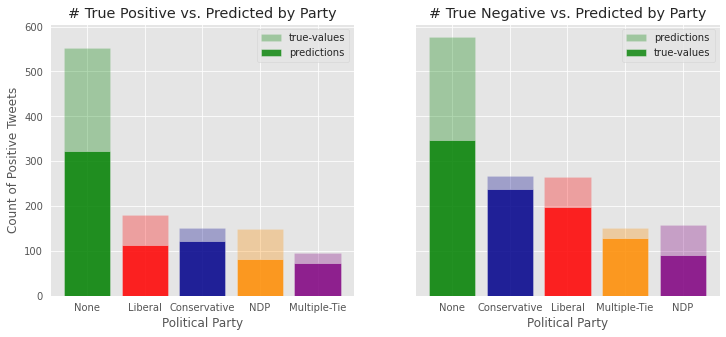

In [ ]:
plt.style.use('ggplot')     # import seaborn 'ggplot' style sheet

fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax[0].bar(prediction_df.index, prediction_df['true-values'], alpha=0.3,
       color = ['green', 'red','darkblue', 'darkorange', 'purple'], 
       label='true-values')
ax[0].bar(prediction_df.index, prediction_df['predictions'], alpha=0.8,
        color = ['green', 'red','darkblue', 'darkorange', 'purple'], 
        label='predictions')
ax[1].bar(neg_prediction_df.index, neg_prediction_df['predictions'], alpha=0.3,
        color = ['green', 'darkblue','red', 'darkorange', 'purple'], 
        label='predictions')
ax[1].bar(neg_prediction_df.index, neg_prediction_df['true-values'], alpha=0.8,
       color = ['green', 'darkblue','red', 'darkorange', 'purple'], 
       label='true-values')
for i in range(2):
    ax[i].set_xlabel('Political Party')
    ax[i].legend()
ax[0].set_ylabel('Count of Positive Tweets')
ax[0].set_title('# True Positive vs. Predicted by Party')
ax[1].set_title('# True Negative vs. Predicted by Party')

plt.show()

**Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns**

* From the graph, whe can see that the model over-predicted positive sentiment and under-predicted negative sentiments for all 3 parties.

* We can see also from the true data that the overall sentiments were very close for all 3 parties.  Since 2019 resulted in a minority-government, this makes sense.

* NLP analytics could be used by political parties to see how they compare to other parties during a campaign if the model could be tuned to be more accurate.  If a party knew that they were subject to more negative tweets, they could counter this using several political/marketing strategies.

#### **4.3 Multi-Classification Models to Predict Reason for Negative Canadian Election Tweet**

* Split the negative Canadian elections tweets into training data (70%) and test data (30%). Use the true sentiment labels in the Canadian elections data instead of your predictions from the previous part. 

**Note.** Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

In [26]:
df2.negative_reason.value_counts()

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

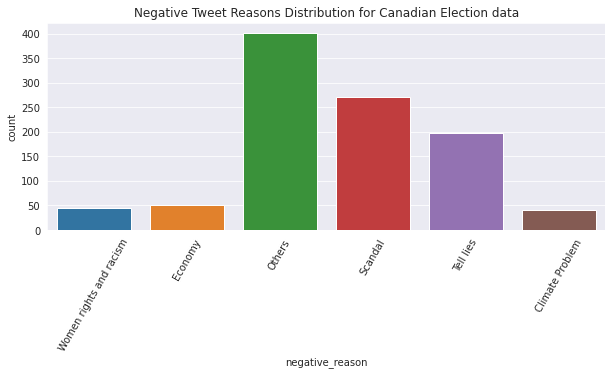

In [27]:
# 0. shorten some label data (negative reasons) for better visual on plot
# And merge 'separation', 'privelege', 'healthcare', 'healthcare and marijuana'
# into 'others' due to low numbers
df2['negative_reason'] = df2['negative_reason'].map(
    {'Women Reproductive right and Racism':'Women rights and racism',
     'Healthcare and Marijuana':'Others', 'Healthcare':'Others', 
     'Privilege':'Others','Separation':'Others'}).fillna(
         df2['negative_reason'])
     
fig, axes = plt.subplots(figsize=(10,6))
sns.countplot(x='negative_reason', data=df2)
plt.title('Negative Tweet Reasons Distribution for Canadian Election data')
plt.xticks(rotation=60)
fig.subplots_adjust(bottom=0.4)

In [28]:
# 1. we split negative tweets only from Canadian election data
negative_tweets = df2[df2['sentiment'] == 0]
print("df2 shape:", df2.shape)
print("negative tweets shape:", negative_tweets.shape,"\n")

# 2. split negative_tweets into X (clean_text) and y (negative_reason)
neg_tweet_X = negative_tweets.clean_text
neg_tweet_y = negative_tweets.negative_reason

print("neg_tweet_X shape:", neg_tweet_X.shape)
print("neg_tweet_y shape:", neg_tweet_y.shape, "\n")

# 3. split data into training and test sets
neg_X_train, neg_X_test, neg_y_train, neg_y_test = train_test_split(neg_tweet_X, 
                                                                    neg_tweet_y, 
                                                                    test_size=0.3)

print("neg_X_train shape: ", neg_X_train.shape)
print("neg_X_test shape: ", neg_X_test.shape)
print("neg_y_train shape: ", neg_y_train.shape)
print("neg_y_test shape: ", neg_y_test.shape)

df2 shape: (2133, 5)
negative tweets shape: (1006, 5) 

neg_tweet_X shape: (1006,)
neg_tweet_y shape: (1006,) 

neg_X_train shape:  (704,)
neg_X_test shape:  (302,)
neg_y_train shape:  (704,)
neg_y_test shape:  (302,)


In [29]:
#4. vectorize using tf-idf since it's generally performed better:
tf_vectorizer = TfidfVectorizer()
neg_X_train_tf_matrix = tf_vectorizer.fit_transform(neg_X_train.astype(str))
neg_X_test_tf_matrix = tf_vectorizer.transform(neg_X_test.astype(str))

print("neg_X_train_tf_matrix shape: ", neg_X_train_tf_matrix.shape)
print("neg_X_test_tf_matrix shape: ", neg_X_test_tf_matrix.shape)

neg_X_train_tf_matrix shape:  (704, 4218)
neg_X_test_tf_matrix shape:  (302, 4218)


#### **4.4 Implement Multi-Classification Models**

* Choose three algorithms from classification algorithms (choose any 3 from logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), train multi-class classification models to predict the
reason for the negative tweets. 
* Tune the hyperparameters and chose the model with best score to test your prediction reason for negative sentiment tweets. There are 10 different negative reasons labelled in the dataset.

##### **4.4A Logistics Regression Hyperparameter Tuning**

In [31]:
#Logistics Regression parameters
params_LR = {'multi_class':['ovr'],           # for multi-class must use 'ovr'
             'solver':['liblinear'],          # for 'ovr' must use 'liblinear'
             'penalty': ['l1','l2'],        # 'none' doesn't work with liblinear
             'C': np.logspace(1,-4,num=6),  # [0.0001, 0.001, 0.01, 0.1, 1, 10]
             'max_iter':[1000]}

#use grid-search to tune hyperparameters:
gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params_LR, 
                  verbose=1, scoring='accuracy')
gs.fit(neg_X_train_tf_matrix, neg_y_train)
print("Best Parameters: ", gs.best_params_)
print("Best Log Regression Validation Accuracy: {:.2%}".format(gs.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.8min finished


Best Parameters:  {'C': 10.0, 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Best Log Regression Validation Accuracy: 58.81%


In [32]:
#Implement best parameters on Logistics Regression model with test data
model = LogisticRegression(penalty='l1',C=10, multi_class='ovr', 
                           solver='liblinear', max_iter=10000)
model.fit(neg_X_train_tf_matrix, neg_y_train)
predictions = model.predict(neg_X_test_tf_matrix)
score = accuracy_score(neg_y_test, predictions)
print("Best Log Regression Test Accuracy: {:.2%}".format(score))
best_predictions = predictions

Best Log Regression Test Accuracy: 58.94%


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


##### **4.5B Naive Bayes Model Hyperparameter Tuning**

In [33]:
#Reference: https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/
#As per ref, use PowerTransformer() on train/test data to hypertune Naive Bayes
pt = PowerTransformer()
neg_X_train_power = pt.fit_transform(neg_X_train_tf_matrix.toarray())
neg_X_test_power = pt.transform(neg_X_test_tf_matrix.toarray())

#Naive Bayes parameters
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)} 

#use grid-search to tune hyperparameters:
gs = GridSearchCV(estimator=GaussianNB(), param_grid=params_NB, verbose=1,
                  scoring='accuracy')
gs.fit(neg_X_train_power, neg_y_train)
print("Best Parameters: ", gs.best_params_)
print("Best Naive Bayes Validation Accuracy: {:.2%}".format(gs.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters:  {'var_smoothing': 1e-05}
Best Naive Bayes Validation Accuracy: 38.06%


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.6s finished


In [34]:
#Implement best parameters on Naive Bayes model with test data
model = GaussianNB(var_smoothing=0.1)
model.fit(neg_X_train_power, neg_y_train)
predictions = model.predict(neg_X_test_power)
score = accuracy_score(neg_y_test, predictions)
print("Best Naive Bayes Test Accuracy: {:.2%}".format(score))

Best Naive Bayes Test Accuracy: 35.43%


##### **4.5C Decision Tree Model Hyperparameter Tuning**

In [35]:
#Implement Decision tree with no tuning to see what max depth will be:
model = DecisionTreeClassifier(random_state=21)
model.fit(neg_X_train_tf_matrix, neg_y_train)
predictions = model.predict(neg_X_test_tf_matrix)
score = accuracy_score(neg_y_test, predictions)
print("Decision Tree Accuracy: {:.2%}".format(score))
print("Max Depth:", model.tree_.max_depth)
best_predictions = predictions

Decision Tree Accuracy: 59.27%
Max Depth: 83


In [36]:
#Decision Tree parameters
params_DT = {'criterion': ['gini','entropy'],       #measure of impurity
             'splitter': ['best', 'random'],        #method to select next feat.
             'random_state':[21],
             'max_depth': np.linspace(10,90,5)}     #depth of tree

#use grid-search to tune hyperparameters:
gs = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params_DT, 
                  verbose=1, scoring='accuracy')
gs.fit(neg_X_train_tf_matrix, neg_y_train)
print("Best Parameters: ", gs.best_params_)
print("Best Decision Tree Validation Accuracy: {:.2%}".format(gs.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters:  {'criterion': 'gini', 'max_depth': 50.0, 'random_state': 21, 'splitter': 'random'}
Best Decision Tree Validation Accuracy: 56.11%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


In [37]:
#Implement best parameters on Decision Tree model with test data
model = DecisionTreeClassifier(criterion='entropy', max_depth=50, 
                               random_state=21, splitter='random')
model.fit(neg_X_train_tf_matrix, neg_y_train)
predictions = model.predict(neg_X_test_tf_matrix)
score = accuracy_score(neg_y_test, predictions)
print("Best Decision Tree Accuracy: {:.2%}".format(score))

Best Decision Tree Accuracy: 54.97%


### **5. Results [25 marks]**

**1. Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results.**

* In the first model, the following validation F1 scores were obtained with the generic twitter data using both bag-of-words(BOW) and TF-IDF (TF):
  * <u>Linear Regression</u>: 91.32% (BOW), 91.89% (TF)
  * <u>Naive Bayes</u>: 83.23% (BOW), 82.68% (TF)
  * <u>LinearSVC</u>: 90.79% (BOW), 91.77% (TF)
  * <u>Decision Tree</u>: 90.27% (BOW), 90.58% (TF)
  * <u>Random Forest</u>: 94.24% (BOW), **94.44% (TF)**
  * <u>XGBoost</u>: 90.82% (BOW), 91.60% (TF)
  * <u>K-Nearest Neighbors</u>: 92.61% (BOW), 91.96% (TF)

* Since Random Forest performed best, it was used on the Canadian Election data and achieved a test F1 score of **53%.** This indicates a case of overfitting as the training accuracy is much higher than the test accuracy.  This could be improved perhaps by better feature engineering (ie. selecting more features) and better data cleaning.  Lemmatization could be a better approach than stemming.

* Many of the current design considerations were dependent on computational speed.  For example, SVD was performed on the dataset to limit to 100 components (features) because the full dataset was taking a long time to converge or it was crashing the working memory.  This was a good compromise since only 2% of the features (100/4700) could account for 40% of the variance.  Further, in my initial attempts with the full dataset, the Linear Regression model accuracy was only a few % points higher.

* Given higher computational capacity (multiple cores), these other approaches could be used to improve accuracy.

**2. Explain how each party is viewed in the public eye based on the sentiment value.** 

* From the results, which can be seen in the graph in section 4.2 and the powerpoint slide #4, all 3 of the major parties had similar numbers of tweets, which seems to indicate a close race.  Further, the main target of negative tweets were the Conservatives and Liberals, which were the primary competitors.  The predictions and true values could be within a margin of error.  Lastly, all parties recieved more negative than positive tweets.

**3. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets.**

* The second model achieved the following accuracies:
  1. <u>Logistics Regression</u>: validation - 58.81%, test - 58.94% 
  2. <u>Naive Bayes</u>: validation - 38.06%, test - 35.43%
  3. <u>Decision Tree</u>: validation - 56.11%, test - 54.97%

* Logistics Regression was the best model overall even when compared with a couple other (bonus) models in the next section:
  4. <u>**(Bonus)** Support Vector Machines</u>: validation - 57.67%, text - 54.30%
  5. <u>**(Bonus)** K-Nearest Neighbors</u>: validation - 52.84%, test - 50.99%

* These models fail because the Canadian election twitter data is a particularly small and unbalanced data set.  We only have 1006 data points and half the potential classes have about 5% of the data:
  * Women's reproductive rights and racism - 45
  * Economy - 51
  * Climate problem - 41  

* Further, if you look at the breakdown of the test set (see figure in Bonus Section), you can see that there are less than 20 examples out of the total 303 test points for the same three categories: Women's rights, economy, climate.

**4. For both models, suggest one way you can improve the accuracy of your models.**

* For the sentiment analysis (first) model, accuracy could be improved with better data cleaning and pre-processing.  For example, I used **stemming** but **lemmatization** could provide more accurate results.  This was avoided due to the higher computational cost.

* For the negative tweet reason prediction (second) model, accuracy could be used with potentially an ensemble method.  Since accuracies were close between training and test data sets, increasing the model complexity could lead to better results.

### **6. Bonus [10% marks]**

We will give up to 10% bonus marks for innovative work going substantially beyond theminimal requirements. Some ideas:

* While the exploratory analysis section requires only two figures, you can explore the data further. You can also display the results of the model visually.

* Hyperparameter tuning for the models

#### **6.1 Exploratory Data Analysis - Feature Importance Visualizations**

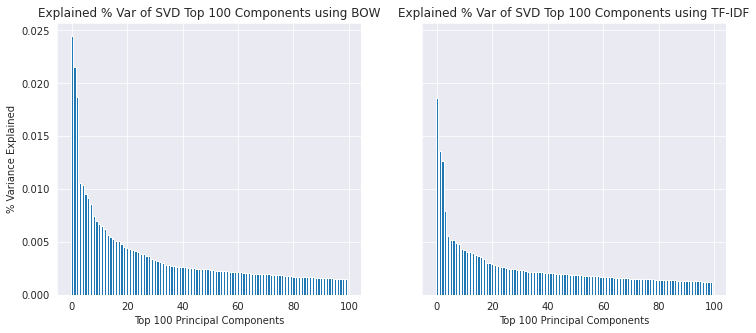

In [62]:
#plot of explained variances
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax[0].bar(x=range(100), height=np.flip(np.sort(svd_cv.explained_variance_ratio_)))
ax[1].bar(x=range(100), height=np.flip(np.sort(svd_tfidf.explained_variance_ratio_)))
ax[0].set_ylabel('% Variance Explained')
for i in range(2):
    ax[i].set_xlabel('Top 100 Principal Components')
ax[0].set_title('Explained % Var of SVD Top 100 Components using BOW')
ax[1].set_title('Explained % Var of SVD Top 100 Components using TF-IDF')
plt.show()

#### **6.2 Visualizations for Model Results**

##### **Visualize Negative Tweet Test Data**

In [38]:
#For the discussion on why the second model does not perform well
#we look at the test data target values
neg_y_test.value_counts()

Others                     122
Scandal                     84
Tell lies                   61
Women rights and racism     12
Economy                     12
Climate Problem             11
Name: negative_reason, dtype: int64

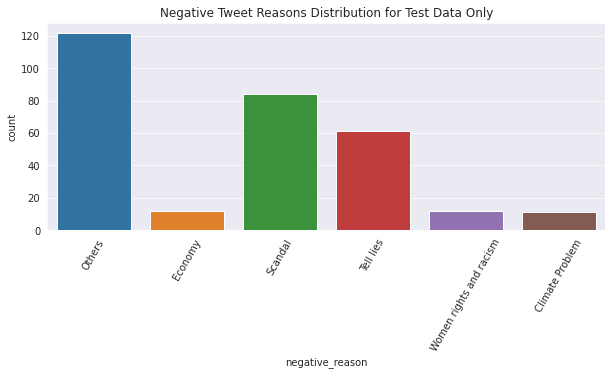

In [39]:
# visually look at the test data targets
neg_y_test_df = pd.DataFrame(neg_y_test)
fig, axes = plt.subplots(figsize=(10,6))
sns.countplot(x='negative_reason', data=neg_y_test_df)
plt.title('Negative Tweet Reasons Distribution for Test Data Only')
plt.xticks(rotation=60)
fig.subplots_adjust(bottom=0.4)

##### **Visualize Second Model Results**

In [40]:
#best_predictions is from linear regression model
reason_predictions = pd.Series(best_predictions).value_counts()
reason_true_values = neg_y_test.value_counts()      #should be 302 data points

#create data frame of true vs. predictions in order to plot
prediction_df = pd.DataFrame([reason_true_values, reason_predictions], 
                             index=['true-values','predictions']).transpose()
prediction_df

,true-values,predictions
Others,122,138
Scandal,84,83
Tell lies,61,50
Women rights and racism,12,6
Economy,12,17
Climate Problem,11,8


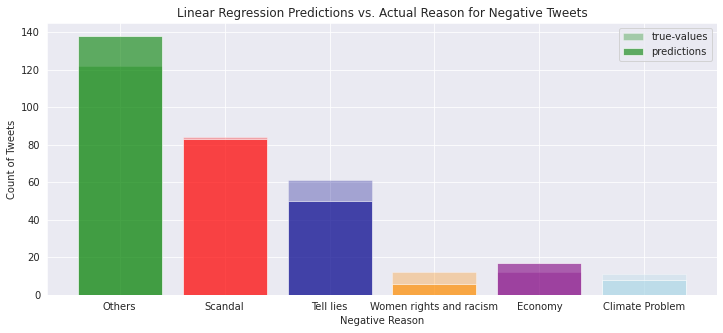

In [41]:
plt.figure(figsize=(12,5))
plt.bar(prediction_df.index, prediction_df['true-values'], alpha=0.3,
       color = ['green', 'red','darkblue', 'darkorange', 'purple', 'lightblue'], 
       label='true-values')
plt.bar(prediction_df.index, prediction_df['predictions'], alpha=0.6,
        color = ['green', 'red','darkblue', 'darkorange', 'purple', 'lightblue'], 
        label='predictions')

plt.xlabel('Negative Reason')
plt.ylabel('Count of Tweets')
plt.title('Linear Regression Predictions vs. Actual Reason for Negative Tweets')
plt.legend()
plt.show()

#### **6.2 Additional Model Hyperparameter Tuning**

In this section, I attempt additional hyper-parameter tuning for some other models for part 4.4 - Multiclass Classifier to predict negative reasons of Canadian election tweets.

##### **6.21 Support Vector Machines (SVM) Model Hyperparameter Tuning**

In [42]:
np.logspace(2,-4, num=7) 

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])

In [43]:
#SVM parameters
params_SVM= {'penalty': ['l1','l2'],      
             'loss': ['hinge', 'squared_hinge'],
             'C': np.logspace(2,-3, num=6),    #[10, 1, 0.1, 0.01, 0.001, 0.001]
             'random_state':[21]}    

#use grid-search to tune hyperparameters:
gs = GridSearchCV(estimator=LinearSVC(), param_grid=params_SVM, 
                  verbose=1, scoring='accuracy')
gs.fit(neg_X_train_tf_matrix, neg_y_train)
print("Best Parameters: ", gs.best_params_)
print("Best Decision Tree Validation Accuracy: {:.2%}".format(gs.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed

Best Parameters:  {'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 21}
Best Decision Tree Validation Accuracy: 57.67%


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.5s finished


In [48]:
#Implement best parameters on SVM model with test data
model = LinearSVC(loss='hinge', C=10, random_state=21)
model.fit(neg_X_train_tf_matrix, neg_y_train)
predictions = model.predict(neg_X_test_tf_matrix)
score = accuracy_score(neg_y_test, predictions)
print("Best SVM Test Accuracy: {:.2%}".format(score))

Best SVM Test Accuracy: 54.30%


##### **6.22 K-Nearest Neighbors Model Hyperparameter Tuning**

In [45]:
#KNN parameters
params_KNN= {'n_neighbors': [4,6,8,10,14,18], 
              'weights': ['uniform', 'distance']}    

#use grid-search to tune hyperparameters:
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_KNN, 
                  verbose=1, scoring='accuracy')
gs.fit(neg_X_train_tf_matrix.toarray(), neg_y_train)
print("Best Parameters: ", gs.best_params_)
print("Best KNN Validation Accuracy: {:.2%}".format(gs.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   52.9s finished


Best Parameters:  {'n_neighbors': 18, 'weights': 'distance'}
Best KNN Validation Accuracy: 52.84%


In [47]:
#Implement best parameters on SVM model with test data
model = KNeighborsClassifier(n_neighbors=18, weights='distance')
model.fit(neg_X_train_tf_matrix, neg_y_train)
predictions = model.predict(neg_X_test_tf_matrix)
score = accuracy_score(neg_y_test, predictions)
print("Best KNN Test Accuracy: {:.2%}".format(score))

Best KNN Test Accuracy: 50.99%
